In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os, sys, math
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
from tensorflow import keras
import shap
from datetime import datetime
from util import preprocess_data, create_dataset
#tf.random.set_seed(131)
plt.rc('font', family='serif')


In [2]:
###########################
####### DEFINE PATHS
###########################
DATA_DIR = "./data/"

FIG_DIR = "./figs-rink/"
if not os.path.exists(FIG_DIR):
    os.mkdir(FIG_DIR)

LOG_DIR = FIG_DIR + "./logs/"
if not os.path.exists(LOG_DIR):
    os.mkdir(LOG_DIR)

In [3]:
###########################
####### DATA PREP
###########################
RUNOFF_NAME = "runoff_basin_5_RinkIsbrae.txt"
runoff = pd.read_csv(DATA_DIR + RUNOFF_NAME, header=0, delim_whitespace=True)
runoff.columns = ['ds', 'runoff']

VEL_NAME = "17_terminus_velocity.xlsx"
xls = pd.ExcelFile(DATA_DIR + VEL_NAME)
vel = pd.read_excel(xls, "date_vel")
term = pd.read_excel(xls, "date_terminus")

# resample data to have uniform temporal frequency
RESAMPLE_FQ = '2W'
vel_resampled = preprocess_data(vel, var_column='vel', date_column='ds', resampling=RESAMPLE_FQ)
term_resampled = preprocess_data(term, var_column='term', date_column='ds', resampling=RESAMPLE_FQ)
runoff_resampled = preprocess_data(runoff, var_column='runoff', date_column='ds', resampling=RESAMPLE_FQ)

# merge the two datasets
merged_data = pd.merge_asof(vel_resampled, runoff_resampled, on='date')
merged_data = pd.merge_asof(merged_data, term_resampled, on='date')

# define the features that are intended to include in training
f_columns = ['vel',
             'runoff',
             'term']

features = merged_data[f_columns]
features.index = merged_data['date']

## define new folders for saving
folder_name = '-'.join(f_columns)

FIG_DIR += folder_name + "/"
if not os.path.exists(FIG_DIR):
    os.mkdir(FIG_DIR)

In [4]:
##############################################
####### TRAIN/TEST SPLIT AND PREPROCESSING 
##############################################
TRAIN_RATIO = 0.650
train_size = int(len(features) * TRAIN_RATIO)
test_size = len(features) - train_size
train, test = features.iloc[0:train_size], features.iloc[train_size:len(features)]

print(len(train), len(test))
##########
## scaling
f_transformer = RobustScaler()
vel_transformer = RobustScaler()

# FIXME: because train[['vel']] is also part of the features, a copy
# of it is created to be able to scale it back otherwise the 
# f_transformer brings back both variables.
# fix to avoid replicating the train[['vel']] transformer
train_y_copy, test_y_copy = train[['vel']].copy(), test[['vel']].copy()

f_transformer = f_transformer.fit(np.asarray(train[f_columns]))
vel_transformer = vel_transformer.fit(train_y_copy)
#vel_transformer = f_transformer

train.loc[:, f_columns] = f_transformer.transform(np.asarray(train[f_columns]))
train['vel'] = vel_transformer.transform(train_y_copy)
#train['vel'] = vel_transformer.transform(train[['vel']])

test.loc[:, f_columns] = f_transformer.transform(np.asarray(test[f_columns]))
test['vel'] = vel_transformer.transform(test_y_copy)
#test['vel'] = vel_transformer.transform(test[['vel']])

###############
# reformulate to a supervised learning problem
if RESAMPLE_FQ=='D':
    time_steps = 360
elif RESAMPLE_FQ=='W':
    time_steps = 50
elif RESAMPLE_FQ=='2W':
    time_steps = 30
elif RESAMPLE_FQ=='M':
    time_steps = 10

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train['vel'], time_steps)
X_test, y_test = create_dataset(test, test['vel'], time_steps)

339 183



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

In [5]:
################
# training specs

# define log path for tensorboard
logdir = LOG_DIR + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

model = keras.Sequential()
#model.add(
#    keras.layers.Conv1D(
#        filters=4, kernel_size=2,
#        strides=1, padding="causal",
#        activation="relu"
#  )
#)
model.add(
  keras.layers.LSTM(
    units=32,
    input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences = True
  )
)

model.add(keras.layers.Dropout(rate=0.5))
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=16,
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=4))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=1))

optimizer = keras.optimizers.Adam(lr=0.0001,
                                     beta_1=0.9,
                                     beta_2=0.999)
#loss = keras.losses.Huber()
#loss = keras.losses.Hinge()
#loss = 'mean_squared_error'
loss = 'mean_absolute_error'
model.compile(loss=loss, optimizer=optimizer)

history = model.fit(
    X_train, y_train, 
    epochs=2000,
    batch_size=200,
    validation_split=0.1,
    shuffle=True,
#    callbacks=[tensorboard_callback]
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 278 samples, validate on 31 samples
Epoch 1/2000
278/278 [==============================] - 1s 4ms/sample - loss: 0.6062 - val_loss: 0.5422
Epoch 2/2000
278/278 [==============================] - 0s 172us/sample - loss: 0.6143 - val_loss: 0.5414
Epoch 3/2000
278/278 [==============================] - 0s 161us/sample - loss: 0.6030 - val_loss: 0.5406
Epoch 4/2000
278/278 [==============================] - 0s 168us/sample - loss: 0.6268 - val_loss: 0.5401
Epoc

Epoch 60/2000
278/278 [==============================] - 0s 181us/sample - loss: 0.4911 - val_loss: 0.5260
Epoch 61/2000
278/278 [==============================] - 0s 189us/sample - loss: 0.5135 - val_loss: 0.5259
Epoch 62/2000
278/278 [==============================] - 0s 185us/sample - loss: 0.4896 - val_loss: 0.5261
Epoch 63/2000
278/278 [==============================] - 0s 191us/sample - loss: 0.4948 - val_loss: 0.5265
Epoch 64/2000
278/278 [==============================] - 0s 187us/sample - loss: 0.4907 - val_loss: 0.5271
Epoch 65/2000
278/278 [==============================] - 0s 190us/sample - loss: 0.4938 - val_loss: 0.5276
Epoch 66/2000
278/278 [==============================] - 0s 178us/sample - loss: 0.4781 - val_loss: 0.5283
Epoch 67/2000
278/278 [==============================] - 0s 186us/sample - loss: 0.4875 - val_loss: 0.5291
Epoch 68/2000
278/278 [==============================] - 0s 191us/sample - loss: 0.4871 - val_loss: 0.5302
Epoch 69/2000
278/278 [==============

Epoch 212/2000
278/278 [==============================] - 0s 192us/sample - loss: 0.4295 - val_loss: 0.4514
Epoch 213/2000
278/278 [==============================] - 0s 184us/sample - loss: 0.4507 - val_loss: 0.4505
Epoch 214/2000
278/278 [==============================] - 0s 182us/sample - loss: 0.4338 - val_loss: 0.4489
Epoch 215/2000
278/278 [==============================] - 0s 205us/sample - loss: 0.4272 - val_loss: 0.4471
Epoch 216/2000
278/278 [==============================] - 0s 195us/sample - loss: 0.4398 - val_loss: 0.4452
Epoch 217/2000
278/278 [==============================] - 0s 198us/sample - loss: 0.4217 - val_loss: 0.4436
Epoch 218/2000
278/278 [==============================] - 0s 188us/sample - loss: 0.4408 - val_loss: 0.4423
Epoch 219/2000
278/278 [==============================] - 0s 186us/sample - loss: 0.4403 - val_loss: 0.4412
Epoch 220/2000
278/278 [==============================] - 0s 183us/sample - loss: 0.4080 - val_loss: 0.4403
Epoch 221/2000
278/278 [====

Epoch 288/2000
278/278 [==============================] - 0s 186us/sample - loss: 0.4345 - val_loss: 0.4148
Epoch 289/2000
278/278 [==============================] - 0s 177us/sample - loss: 0.4408 - val_loss: 0.4141
Epoch 290/2000
278/278 [==============================] - 0s 182us/sample - loss: 0.4462 - val_loss: 0.4134
Epoch 291/2000
278/278 [==============================] - 0s 175us/sample - loss: 0.4283 - val_loss: 0.4131
Epoch 292/2000
278/278 [==============================] - 0s 184us/sample - loss: 0.4216 - val_loss: 0.4133
Epoch 293/2000
278/278 [==============================] - 0s 183us/sample - loss: 0.4258 - val_loss: 0.4139
Epoch 294/2000
278/278 [==============================] - 0s 180us/sample - loss: 0.4431 - val_loss: 0.4140
Epoch 295/2000
278/278 [==============================] - 0s 184us/sample - loss: 0.4231 - val_loss: 0.4139
Epoch 296/2000
278/278 [==============================] - 0s 185us/sample - loss: 0.4030 - val_loss: 0.4140
Epoch 297/2000
278/278 [====

Epoch 364/2000
278/278 [==============================] - 0s 180us/sample - loss: 0.4052 - val_loss: 0.4075
Epoch 365/2000
278/278 [==============================] - 0s 178us/sample - loss: 0.4060 - val_loss: 0.4076
Epoch 366/2000
278/278 [==============================] - 0s 186us/sample - loss: 0.4133 - val_loss: 0.4077
Epoch 367/2000
278/278 [==============================] - 0s 181us/sample - loss: 0.4158 - val_loss: 0.4076
Epoch 368/2000
278/278 [==============================] - 0s 183us/sample - loss: 0.4351 - val_loss: 0.4077
Epoch 369/2000
278/278 [==============================] - 0s 180us/sample - loss: 0.3933 - val_loss: 0.4073
Epoch 370/2000
278/278 [==============================] - 0s 188us/sample - loss: 0.3953 - val_loss: 0.4065
Epoch 371/2000
278/278 [==============================] - 0s 180us/sample - loss: 0.3941 - val_loss: 0.4060
Epoch 372/2000
278/278 [==============================] - 0s 182us/sample - loss: 0.4174 - val_loss: 0.4055
Epoch 373/2000
278/278 [====

Epoch 440/2000
278/278 [==============================] - 0s 184us/sample - loss: 0.4263 - val_loss: 0.3968
Epoch 441/2000
278/278 [==============================] - 0s 181us/sample - loss: 0.4035 - val_loss: 0.3976
Epoch 442/2000
278/278 [==============================] - 0s 180us/sample - loss: 0.3899 - val_loss: 0.3978
Epoch 443/2000
278/278 [==============================] - 0s 179us/sample - loss: 0.3885 - val_loss: 0.3976
Epoch 444/2000
278/278 [==============================] - 0s 184us/sample - loss: 0.3912 - val_loss: 0.3976
Epoch 445/2000
278/278 [==============================] - 0s 177us/sample - loss: 0.4001 - val_loss: 0.3974
Epoch 446/2000
278/278 [==============================] - 0s 184us/sample - loss: 0.4003 - val_loss: 0.3969
Epoch 447/2000
278/278 [==============================] - 0s 183us/sample - loss: 0.3946 - val_loss: 0.3966
Epoch 448/2000
278/278 [==============================] - 0s 182us/sample - loss: 0.4148 - val_loss: 0.3962
Epoch 449/2000
278/278 [====

Epoch 516/2000
278/278 [==============================] - 0s 181us/sample - loss: 0.3906 - val_loss: 0.3845
Epoch 517/2000
278/278 [==============================] - 0s 180us/sample - loss: 0.4235 - val_loss: 0.3849
Epoch 518/2000
278/278 [==============================] - 0s 181us/sample - loss: 0.3946 - val_loss: 0.3853
Epoch 519/2000
278/278 [==============================] - 0s 182us/sample - loss: 0.4023 - val_loss: 0.3856
Epoch 520/2000
278/278 [==============================] - 0s 211us/sample - loss: 0.3967 - val_loss: 0.3861
Epoch 521/2000
278/278 [==============================] - 0s 181us/sample - loss: 0.3912 - val_loss: 0.3871
Epoch 522/2000
278/278 [==============================] - 0s 189us/sample - loss: 0.4230 - val_loss: 0.3883
Epoch 523/2000
278/278 [==============================] - 0s 181us/sample - loss: 0.4083 - val_loss: 0.3895
Epoch 524/2000
278/278 [==============================] - 0s 183us/sample - loss: 0.3945 - val_loss: 0.3906
Epoch 525/2000
278/278 [====

Epoch 592/2000
278/278 [==============================] - 0s 178us/sample - loss: 0.3898 - val_loss: 0.3756
Epoch 593/2000
278/278 [==============================] - 0s 182us/sample - loss: 0.4197 - val_loss: 0.3752
Epoch 594/2000
278/278 [==============================] - 0s 178us/sample - loss: 0.3896 - val_loss: 0.3749
Epoch 595/2000
278/278 [==============================] - 0s 179us/sample - loss: 0.3791 - val_loss: 0.3752
Epoch 596/2000
278/278 [==============================] - 0s 186us/sample - loss: 0.4148 - val_loss: 0.3758
Epoch 597/2000
278/278 [==============================] - 0s 184us/sample - loss: 0.3803 - val_loss: 0.3771
Epoch 598/2000
278/278 [==============================] - 0s 184us/sample - loss: 0.3836 - val_loss: 0.3781
Epoch 599/2000
278/278 [==============================] - 0s 181us/sample - loss: 0.3992 - val_loss: 0.3792
Epoch 600/2000
278/278 [==============================] - 0s 181us/sample - loss: 0.4022 - val_loss: 0.3806
Epoch 601/2000
278/278 [====

Epoch 668/2000
278/278 [==============================] - 0s 187us/sample - loss: 0.4037 - val_loss: 0.3804
Epoch 669/2000
278/278 [==============================] - 0s 179us/sample - loss: 0.3725 - val_loss: 0.3787
Epoch 670/2000
278/278 [==============================] - 0s 184us/sample - loss: 0.3843 - val_loss: 0.3778
Epoch 671/2000
278/278 [==============================] - 0s 177us/sample - loss: 0.3869 - val_loss: 0.3770
Epoch 672/2000
278/278 [==============================] - 0s 181us/sample - loss: 0.3808 - val_loss: 0.3759
Epoch 673/2000
278/278 [==============================] - 0s 192us/sample - loss: 0.3710 - val_loss: 0.3750
Epoch 674/2000
278/278 [==============================] - 0s 185us/sample - loss: 0.3781 - val_loss: 0.3741
Epoch 675/2000
278/278 [==============================] - 0s 195us/sample - loss: 0.3808 - val_loss: 0.3732
Epoch 676/2000
278/278 [==============================] - 0s 181us/sample - loss: 0.3842 - val_loss: 0.3729
Epoch 677/2000
278/278 [====

Epoch 744/2000
278/278 [==============================] - 0s 190us/sample - loss: 0.4026 - val_loss: 0.3740
Epoch 745/2000
278/278 [==============================] - 0s 185us/sample - loss: 0.4027 - val_loss: 0.3731
Epoch 746/2000
278/278 [==============================] - 0s 178us/sample - loss: 0.3942 - val_loss: 0.3721
Epoch 747/2000
278/278 [==============================] - 0s 183us/sample - loss: 0.3688 - val_loss: 0.3712
Epoch 748/2000
278/278 [==============================] - 0s 185us/sample - loss: 0.3897 - val_loss: 0.3705
Epoch 749/2000
278/278 [==============================] - 0s 181us/sample - loss: 0.3772 - val_loss: 0.3695
Epoch 750/2000
278/278 [==============================] - 0s 195us/sample - loss: 0.3813 - val_loss: 0.3694
Epoch 751/2000
278/278 [==============================] - 0s 179us/sample - loss: 0.3770 - val_loss: 0.3696
Epoch 752/2000
278/278 [==============================] - 0s 193us/sample - loss: 0.4001 - val_loss: 0.3703
Epoch 753/2000
278/278 [====

Epoch 820/2000
278/278 [==============================] - 0s 190us/sample - loss: 0.3849 - val_loss: 0.3664
Epoch 821/2000
278/278 [==============================] - 0s 185us/sample - loss: 0.3803 - val_loss: 0.3659
Epoch 822/2000
278/278 [==============================] - 0s 189us/sample - loss: 0.3710 - val_loss: 0.3656
Epoch 823/2000
278/278 [==============================] - 0s 187us/sample - loss: 0.3767 - val_loss: 0.3654
Epoch 824/2000
278/278 [==============================] - 0s 182us/sample - loss: 0.3881 - val_loss: 0.3648
Epoch 825/2000
278/278 [==============================] - 0s 193us/sample - loss: 0.3910 - val_loss: 0.3643
Epoch 826/2000
278/278 [==============================] - 0s 190us/sample - loss: 0.3893 - val_loss: 0.3636
Epoch 827/2000
278/278 [==============================] - 0s 190us/sample - loss: 0.3895 - val_loss: 0.3628
Epoch 828/2000
278/278 [==============================] - 0s 184us/sample - loss: 0.3769 - val_loss: 0.3622
Epoch 829/2000
278/278 [====

Epoch 896/2000
278/278 [==============================] - 0s 186us/sample - loss: 0.3803 - val_loss: 0.3689
Epoch 897/2000
278/278 [==============================] - 0s 193us/sample - loss: 0.3496 - val_loss: 0.3684
Epoch 898/2000
278/278 [==============================] - 0s 193us/sample - loss: 0.3812 - val_loss: 0.3680
Epoch 899/2000
278/278 [==============================] - 0s 192us/sample - loss: 0.3839 - val_loss: 0.3674
Epoch 900/2000
278/278 [==============================] - 0s 193us/sample - loss: 0.3956 - val_loss: 0.3670
Epoch 901/2000
278/278 [==============================] - 0s 202us/sample - loss: 0.3831 - val_loss: 0.3662
Epoch 902/2000
278/278 [==============================] - 0s 193us/sample - loss: 0.3558 - val_loss: 0.3658
Epoch 903/2000
278/278 [==============================] - 0s 197us/sample - loss: 0.3782 - val_loss: 0.3657
Epoch 904/2000
278/278 [==============================] - 0s 183us/sample - loss: 0.3704 - val_loss: 0.3653
Epoch 905/2000
278/278 [====

Epoch 972/2000
278/278 [==============================] - 0s 187us/sample - loss: 0.3838 - val_loss: 0.3603
Epoch 973/2000
278/278 [==============================] - 0s 187us/sample - loss: 0.3568 - val_loss: 0.3610
Epoch 974/2000
278/278 [==============================] - 0s 190us/sample - loss: 0.3708 - val_loss: 0.3620
Epoch 975/2000
278/278 [==============================] - 0s 198us/sample - loss: 0.3906 - val_loss: 0.3630
Epoch 976/2000
278/278 [==============================] - 0s 186us/sample - loss: 0.4067 - val_loss: 0.3633
Epoch 977/2000
278/278 [==============================] - 0s 188us/sample - loss: 0.3679 - val_loss: 0.3632
Epoch 978/2000
278/278 [==============================] - 0s 187us/sample - loss: 0.3735 - val_loss: 0.3632
Epoch 979/2000
278/278 [==============================] - 0s 189us/sample - loss: 0.3572 - val_loss: 0.3633
Epoch 980/2000
278/278 [==============================] - 0s 191us/sample - loss: 0.3883 - val_loss: 0.3632
Epoch 981/2000
278/278 [====

278/278 [==============================] - 0s 192us/sample - loss: 0.3705 - val_loss: 0.3452
Epoch 1123/2000
278/278 [==============================] - 0s 190us/sample - loss: 0.3499 - val_loss: 0.3447
Epoch 1124/2000
278/278 [==============================] - 0s 185us/sample - loss: 0.3680 - val_loss: 0.3445
Epoch 1125/2000
278/278 [==============================] - 0s 192us/sample - loss: 0.3777 - val_loss: 0.3441
Epoch 1126/2000
278/278 [==============================] - 0s 191us/sample - loss: 0.3552 - val_loss: 0.3439
Epoch 1127/2000
278/278 [==============================] - 0s 188us/sample - loss: 0.3700 - val_loss: 0.3434
Epoch 1128/2000
278/278 [==============================] - 0s 220us/sample - loss: 0.3483 - val_loss: 0.3425
Epoch 1129/2000
278/278 [==============================] - 0s 184us/sample - loss: 0.3570 - val_loss: 0.3418
Epoch 1130/2000
278/278 [==============================] - 0s 189us/sample - loss: 0.3695 - val_loss: 0.3409
Epoch 1131/2000
278/278 [==========

278/278 [==============================] - 0s 193us/sample - loss: 0.3672 - val_loss: 0.3425
Epoch 1273/2000
278/278 [==============================] - 0s 189us/sample - loss: 0.3437 - val_loss: 0.3424
Epoch 1274/2000
278/278 [==============================] - 0s 199us/sample - loss: 0.3501 - val_loss: 0.3419
Epoch 1275/2000
278/278 [==============================] - 0s 187us/sample - loss: 0.3554 - val_loss: 0.3421
Epoch 1276/2000
278/278 [==============================] - 0s 188us/sample - loss: 0.3423 - val_loss: 0.3426
Epoch 1277/2000
278/278 [==============================] - 0s 188us/sample - loss: 0.3696 - val_loss: 0.3429
Epoch 1278/2000
278/278 [==============================] - 0s 189us/sample - loss: 0.3409 - val_loss: 0.3434
Epoch 1279/2000
278/278 [==============================] - 0s 197us/sample - loss: 0.3484 - val_loss: 0.3440
Epoch 1280/2000
278/278 [==============================] - 0s 189us/sample - loss: 0.3453 - val_loss: 0.3443
Epoch 1281/2000
278/278 [==========

278/278 [==============================] - 0s 194us/sample - loss: 0.3427 - val_loss: 0.3331
Epoch 1423/2000
278/278 [==============================] - 0s 187us/sample - loss: 0.3717 - val_loss: 0.3337
Epoch 1424/2000
278/278 [==============================] - 0s 202us/sample - loss: 0.3246 - val_loss: 0.3333
Epoch 1425/2000
278/278 [==============================] - 0s 191us/sample - loss: 0.3488 - val_loss: 0.3323
Epoch 1426/2000
278/278 [==============================] - 0s 189us/sample - loss: 0.3513 - val_loss: 0.3311
Epoch 1427/2000
278/278 [==============================] - 0s 186us/sample - loss: 0.3334 - val_loss: 0.3300
Epoch 1428/2000
278/278 [==============================] - 0s 198us/sample - loss: 0.3421 - val_loss: 0.3292
Epoch 1429/2000
278/278 [==============================] - 0s 190us/sample - loss: 0.3680 - val_loss: 0.3286
Epoch 1430/2000
278/278 [==============================] - 0s 181us/sample - loss: 0.3588 - val_loss: 0.3285
Epoch 1431/2000
278/278 [==========

278/278 [==============================] - 0s 191us/sample - loss: 0.3488 - val_loss: 0.3299
Epoch 1573/2000
278/278 [==============================] - 0s 183us/sample - loss: 0.3543 - val_loss: 0.3309
Epoch 1574/2000
278/278 [==============================] - 0s 182us/sample - loss: 0.3450 - val_loss: 0.3313
Epoch 1575/2000
278/278 [==============================] - 0s 200us/sample - loss: 0.3474 - val_loss: 0.3313
Epoch 1576/2000
278/278 [==============================] - 0s 189us/sample - loss: 0.3560 - val_loss: 0.3308
Epoch 1577/2000
278/278 [==============================] - 0s 194us/sample - loss: 0.3521 - val_loss: 0.3298
Epoch 1578/2000
278/278 [==============================] - 0s 209us/sample - loss: 0.3456 - val_loss: 0.3289
Epoch 1579/2000
278/278 [==============================] - 0s 183us/sample - loss: 0.3543 - val_loss: 0.3281
Epoch 1580/2000
278/278 [==============================] - 0s 195us/sample - loss: 0.3486 - val_loss: 0.3273
Epoch 1581/2000
278/278 [==========

278/278 [==============================] - 0s 189us/sample - loss: 0.3604 - val_loss: 0.3154
Epoch 1723/2000
278/278 [==============================] - 0s 196us/sample - loss: 0.3392 - val_loss: 0.3148
Epoch 1724/2000
278/278 [==============================] - 0s 188us/sample - loss: 0.3469 - val_loss: 0.3143
Epoch 1725/2000
278/278 [==============================] - 0s 188us/sample - loss: 0.3580 - val_loss: 0.3142
Epoch 1726/2000
278/278 [==============================] - 0s 188us/sample - loss: 0.3377 - val_loss: 0.3141
Epoch 1727/2000
278/278 [==============================] - 0s 197us/sample - loss: 0.3386 - val_loss: 0.3145
Epoch 1728/2000
278/278 [==============================] - 0s 194us/sample - loss: 0.3378 - val_loss: 0.3154
Epoch 1729/2000
278/278 [==============================] - 0s 186us/sample - loss: 0.3256 - val_loss: 0.3157
Epoch 1730/2000
278/278 [==============================] - 0s 192us/sample - loss: 0.3323 - val_loss: 0.3154
Epoch 1731/2000
278/278 [==========

278/278 [==============================] - 0s 193us/sample - loss: 0.3275 - val_loss: 0.3045
Epoch 1873/2000
278/278 [==============================] - 0s 183us/sample - loss: 0.3433 - val_loss: 0.3033
Epoch 1874/2000
278/278 [==============================] - 0s 190us/sample - loss: 0.3393 - val_loss: 0.3034
Epoch 1875/2000
278/278 [==============================] - 0s 189us/sample - loss: 0.3475 - val_loss: 0.3033
Epoch 1876/2000
278/278 [==============================] - 0s 190us/sample - loss: 0.3416 - val_loss: 0.3033
Epoch 1877/2000
278/278 [==============================] - 0s 186us/sample - loss: 0.3393 - val_loss: 0.3032
Epoch 1878/2000
278/278 [==============================] - 0s 179us/sample - loss: 0.3603 - val_loss: 0.3027
Epoch 1879/2000
278/278 [==============================] - 0s 187us/sample - loss: 0.3509 - val_loss: 0.3029
Epoch 1880/2000
278/278 [==============================] - 0s 185us/sample - loss: 0.3539 - val_loss: 0.3036
Epoch 1881/2000
278/278 [==========

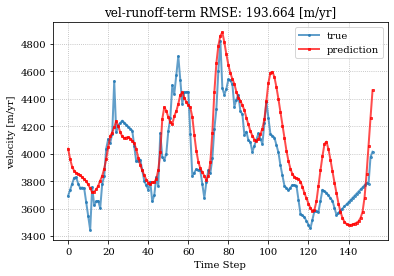

In [6]:
##############################
######CHECK LOSSES AND PLOTS
##############################
## check losses
plt.plot(history.history['loss'], label='train', alpha=0.75)
plt.plot(history.history['val_loss'], label='validation', alpha=0.75)
plt.grid(linestyle='dotted')
plt.xlabel("# epochs")
plt.ylabel("loss")
#plt.ylim([0,0.5])
plt.title(folder_name)
plt.legend(); plt.savefig(FIG_DIR + "rink-train-val-loss.png", dpi=300)
plt.clf()

## prediction
y_pred = model.predict(X_test)

# revert and scale back
y_train_inv = vel_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = vel_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = vel_transformer.inverse_transform(y_pred)

rmse = math.sqrt(mean_squared_error(y_test_inv.reshape(-1, 1), y_pred_inv))
################
## plots results
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true", alpha=0.6)
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction", alpha=0.6)
plt.ylabel('velocity [m/yr]')
plt.xlabel('Time Step')
plt.legend(loc='best')
plt.title(folder_name + ' RMSE: %.3f [m/yr]' % rmse)
plt.savefig(FIG_DIR + "rink-check.png", dpi=300)
plt.clf()

## plot zoomed in to validation set
#plt.plot(test.index[time_steps:], y_test_inv.flatten(), label='true', alpha=0.7, linewidth=2, marker='o', markersize=2, color='C0')
#plt.plot(test.index[time_steps:], y_pred_inv.flatten(), label='prediction', alpha=0.7, linewidth=2, marker='s', markersize=2, color='r')
plt.plot(y_test_inv.flatten(), label='true', alpha=0.7, linewidth=2, marker='o', markersize=2, color='C0')
plt.plot(y_pred_inv.flatten(), label='prediction', alpha=0.7, linewidth=2, marker='s', markersize=2, color='r')
plt.ylabel('velocity [m/yr]')
plt.xlabel('Time Step')
plt.xticks(rotation=0)
plt.title(folder_name + ' RMSE: %.3f [m/yr]' % rmse)
plt.legend(); plt.grid(linestyle='dotted')
plt.savefig(FIG_DIR + "rink-check-zoom.png", dpi=300)
#plt.clf()


## Experiments with SHAP

In [7]:
## SHAP STUFF
explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

In [16]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][-1], X_test[-1], feature_names=f_columns)

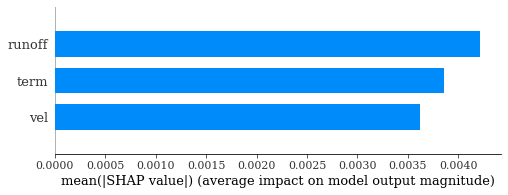

In [44]:
i = 17
shap.summary_plot(shap_values[0][:, i, :], X_test[:][:, i, :], feature_names=f_columns, plot_type="bar")

In [15]:
X_test[:][:, -1, :].shape

(153, 3)

In [26]:
X_test.shape

(153, 30, 3)